In [1]:
%pylab inline

from __future__ import print_function
from __future__ import division

import sklearn
import numpy
import scipy
import pandas
import matplotlib
import seaborn

import json
import re

from matplotlib import pyplot
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['figure.figsize'] = 15, 8

# Useful functions

In [3]:
def avg(x):
    return sum(x) / len(x)

# Getting messages

In [4]:
def getlinesep(mail):
    lineseps = ['\r\n', '\n']
    return next(x for x in lineseps if 2 * x in mail)

def parse(mail):
    ls = getlinesep(mail)
    bs = 2 * ls
    
    header, body = mail.split(bs, 1)
    header = header.replace(ls + '\t', ' ').replace(ls + ' ', ' ')
    
    header = [(str(x).replace('_', '--'), y) for x, y in [z.split(':', 1) for z in header.split(ls)]]
    body = ('body', body)
    
    return header + [body] + [('my_linesep', ls)]

def try_parse(mail):
    try:
        return parse(mail)
    except ValueError:
        return {'my_unparseable': True, 'my_reason': 'badheader'}
    except StopIteration:
        return {'my_unparseable': True, 'my_reason': 'nosep'}

In [5]:
ham_json = json.load(open('data/ham_train.json'))
ham = map(try_parse, ham_json)
print('{}/{} unparseable messages'.format(len([x for x in ham if 'unparseable' in x]), len(ham_json)))

%xdel ham_json

0/40500 unparseable messages


In [16]:
pandas.DataFrame(map(dict, ham)).to_csv('data/ham_train.csv', index = True, header = True, encoding = 'utf-8', index_label = 'num')

In [6]:
spam_json = json.load(open('data/spam_train.json'))
spam = map(try_parse, spam_json)
print('{}/{} unparseable messages'.format(len([x for x in spam if 'unparseable' in x]), len(spam_json)))

%xdel spam_json

0/40500 unparseable messages


In [8]:
ham_messages = 40499
pandas.DataFrame(map(dict, spam), index = range(ham_messages + 1, ham_messages + len(spam) + 1)).to_csv('data/spam_train.csv', index = True, header = True, encoding = 'utf-8', index_label = 'num')

In [7]:
pandas.DataFrame(map(dict, ham + spam)).to_csv('data/train.csv', index = True, header = True, encoding = 'utf-8', index_label = 'num')

# Feature extraction

In [15]:
table = pandas.DataFrame(map(dict, ham + spam))
answers = pandas.Series(['ham'] * len(ham) + ['spam'] * len(spam))
%xdel ham
%xdel spam

In [24]:
# Agregar a table cierta transformación de algunas de sus columnas.
def addColFeatures(name, f, colsF = lambda x: True, objects_only = True, source = table, sink = table):
    if not any([x.endswith('_' + name) for x in source.columns]):
        cols = source.columns
        if objects_only:
            # Perdón Wilkinson
            cols = cols[cols.map(lambda x: isinstance(source[x].dropna().iloc[0], basestring))]

        cols = cols[cols.map(colsF)]
        sink[cols + '_' + name] = source[cols].apply(lambda x: f(x.dropna()))
        
        print('Added feature {}'.format(name))

## Length

In [17]:
addColFeatures('length', lambda x: x.str.len())

Added feature length


## Separation

El único buen separador encontrado parece ser la coma.

In [18]:
sep = ','
addColFeatures(
    'fields',
    lambda x: x.str.count(sep) + 1,
    lambda x: table[x].str.contains(sep).any()
)

Added feature fields


In [19]:
addColFeatures(
    'avgFieldLength',
    lambda x: x.str.split(sep).apply(lambda x: avg(map(len, x))),
    lambda x: table[x].str.contains(sep).any()
)

Added feature avgFieldLength


## Wordcount

In [20]:
addColFeatures(
    'words',
    lambda x: x.str.strip().str.count(' ') + 1,
    lambda x: table[x].str.strip().str.contains(' ').any()
)

Added feature words


In [21]:
addColFeatures(
    'avgWordLength',
    lambda x: x.str.strip().str.split(' ').apply(lambda x: avg(map(len, x))),
    lambda x: table[x].str.strip().str.contains(' ').any()
)

Added feature avgWordLength


## Existence

In [22]:
addColFeatures(
    'exists',
    lambda x: x.notnull()
)

Added feature exists


## All of them by chunks

### Parsing the stuff

In [5]:
class ExtractedFeature(object):
    def __init__(self, name, trans, filt = lambda x: True, fillna = numpy.nan):
        self.name = name
        self.trans = trans
        self.filt = filt
        self.fillna = fillna
    
    def extractFrom(self, table):
        # cols = [x for x in table.columns if isinstance(table[x].dropna().iloc[0], basestring)]
        cols = table.columns.difference(table._get_numeric_data().columns)
        cols = pandas.Index(x for x in cols if table[x].notnull().any() and self.filt(table[x].dropna()))
        
        return (
            table[cols].apply(lambda x: self.trans(x.dropna()))
            .rename(columns = lambda x: x + '_' + self.name)
            .fillna(self.fillna)
        )

In [6]:
sep = ','

features = [
    ExtractedFeature('length', lambda x: x.str.len()),
    ExtractedFeature('fields', lambda x: x.str.count(sep) + 1, lambda x: x.str.contains(sep).any()),
    ExtractedFeature('avgFieldLength', lambda x: x.str.split(sep).apply(lambda x: avg(map(len, x))), lambda x: x.str.contains(sep).any()),
    ExtractedFeature('words', lambda x: x.str.strip().str.count(' ') + 1, lambda x: x.str.strip().str.contains(' ').any()),
    ExtractedFeature('avgWordLength', lambda x: x.str.strip().str.split(' ').apply(lambda x: avg(map(len, x))), lambda x: x.str.strip().str.contains(' ').any()),
    ExtractedFeature('exists', lambda x: x.notnull(), fillna = False),
]

def extractAll(table):
    return pandas.concat(map(lambda x: x.extractFrom(table), features), axis = 1)

### Getting the data

In [10]:
train = pandas.read_csv('data/train.csv', index_col = 'num', encoding = 'utf-8', chunksize = 10000, dtype = object)

first = True
for e, chunk in enumerate(train):
    try:
        t = extractAll(chunk)
        t['spam'] = t.index >= 40500
        # Ugly hack: if b : Bool, b * 1 : Int
        (t * 1).to_csv('dev/features.csv', index = True, header = first, mode = 'w' if first else 'a')
        first = False
    except Exception as t:
        print('Exception "{}" on chunk {}'.format(t, e))

Exception "Reindexing only valid with uniquely valued Index objects" on chunk 4
Exception "cannot reindex from a duplicate axis" on chunk 5
Exception "cannot reindex from a duplicate axis" on chunk 6
Exception "cannot reindex from a duplicate axis" on chunk 7


In [ ]:
lim = 40500
pandas.DataFrame(''

# Downloading

In [16]:
table[[x for x in table.columns if '_' in x]].to_csv('features50k.csv', index = True, header = True, index_label = 'n50k')
answers.to_frame('answer').to_csv('answers20k.csv', index = True, header = True, index_label = 'n50k')

# Analysis

In [18]:
table.describe(include = 'all')

,alternate-recipient,approved,auto-submitted,bcc,body,cc,comments,content-alias,content-class,content-disposition,...,x-from_avgWordSize,x-ironport-av_avgWordSize,x-mailer_avgWordSize,x-mdav-processed_avgWordSize,x-mimetrack_avgWordSize,x-originalarrivaltime_avgWordSize,x-spam-processed_avgWordSize,x-spam-status_avgWordSize,x-to_avgWordSize,x-webmail-time_avgWordSize
count,6,4,15,2197,9989,2394,12,1,9,15,...,5001.000000,1.0,860.000000,1.0,1.0,24.000000,1.000000,5.000000,5000.000000,4.000000
unique,2,1,2,1174,9768,1325,1,1,1,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,allowed,yes (127.0.0.1),auto-generated (failure),"albert.meyers#####, bill.williams#####, craig...","<!doctype html public ""-//w3c//dtd html 3.2//e...","albert.meyers#####, bill.williams#####, craig...",this is a test,9506728538872388031,urn:content-classes:message,inline,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,4,9,389,25,389,12,1,9,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.384580,10.0,11.629779,6.0,7.0,8.890625,6.714286,12.413333,11.383116,4.333333
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.582935,NaN,5.672842,NaN,NaN,1.037187,NaN,0.808840,6.481160,0.000000
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.333333,10.0,0.000000,6.0,7.0,4.333333,6.714286,11.666667,0.000000,4.333333
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


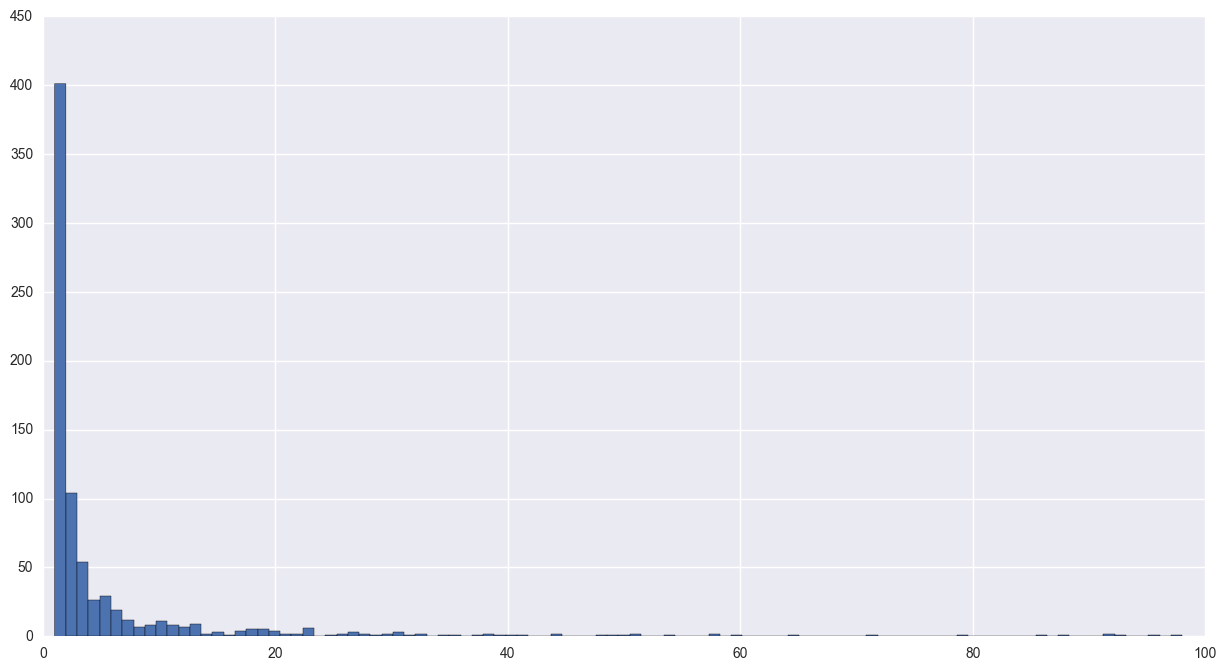

In [10]:
a = table[[x for x in table.columns if '_' not in x]].apply(pandas.Series.nunique)
a[a < 100].hist(bins = 100)

In [67]:
table['Content-Class'].str.strip().value_counts()

urn:content-classes:message            1184
urn:content-classes:appointment         130
urn:content-classes:message/text         68
urn:content-classes:NEWSLETTER           66
urn:content-classes:newsletter           33
urn:content-classes:calendarmessage      20
urn:content-classes:mdn                   4
hh:content-classes:message                1
n:content-classes:message                 1
nyu:content-classes:message               1
ojr:content-classes:message               1
w:content-classes:message                 1
xa:content-classes:message                1
k:content-classes:message                 1
odc:content-classes:message               1
i:content-classes:message                 1
ff:content-classes:message                1
ss:content-classes:message                1
nls:content-classes:message               1
rvn:content-classes:message               1
Name: Content-Class, dtype: int64

In [45]:
cols = table[[x for x in table.columns if '_' not in x]]
a = pandas.DataFrame({
        'nunique': cols.apply(pandas.Series.nunique),
        'notnull': cols.count()
})

In [66]:
a[a.nunique <= 20].sort_values(by = 'notnull', ascending = False)

,notnull,nunique
linesep,80841,2
mime-version,35462,12
content-transfer-encoding,30458,7
Content-Transfer-Encoding,24288,16
x-bcc,17179,7
x-filename,17179,17
x-origin,17179,7
X-MS-Has-Attach,14865,3
x-priority,14862,9
content-class,13926,5


# Categorization and OneHotEncoding

In [93]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

In [ ]:
smol = table[[x for x in table.columns if
    '_' not in x and
    'bcc' not in x and
    table[x].nunique() <= 20 and
    table[x].count() >= 500
]]

In [ ]:
dv = DictVectorizer()
dicts = dv.fit_transform(smol.fillna('NaN').T.to_dict().values())

In [ ]:
ohe = OneHotEncoder()
a = ohe.fit_transform(dicts.toarray())

In [ ]:
a[:5, :5].toarray()

In [ ]:
a

In [ ]:
len(dv.vocabulary_)

# Whitespace

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

